In [96]:
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

In [80]:
N = 4000
n_factor = 3
X = np.random.multivariate_normal(np.zeros(n_factor-1), cov = np.eye(n_factor-1), size = N)
def add_const(X):
    return np.vstack((np.ones(len(X)), X.T)).T # 定数項を追加
X = add_const(X)
w_vec = np.random.normal(0.0, size = n_factor)
sigma = 5.0
y = X.dot(w_vec.T) + sigma * np.random.normal(0.0, size = len(X))
print(X, y, w_vec)

[[ 1.         -0.69370865  0.04259453]
 [ 1.         -0.85947486  1.35897193]
 [ 1.          0.51891667 -0.54341027]
 ...
 [ 1.         -2.49015871 -1.86300865]
 [ 1.          1.08145731 -0.30417299]
 [ 1.         -0.68634135 -0.2885439 ]] [-9.91619113  4.58282901 -4.11871056 ...  1.35505181  3.43775706
 -0.26645951] [-0.47370852 -0.88350096 -0.56065843]


In [81]:
class LinearRegression:
    def __init__(self, lambda_ridge = 0.0):
        self.lambda_ridge = lambda_ridge
        
    def fit(self, y, X): # Yは(N, n_stocks)
        N, n_factors = len(X), len(X[0])
        self.y = y.copy()
        self.X = X.copy()
        Lambda_ridge = self.lambda_ridge*np.eye(n_factors)

        self.W = np.linalg.inv(self.X.T.dot(self.X) + Lambda_ridge).dot(self.X.T).dot(self.y)
        self.y_pred = self.X.dot(self.W)
        self.sigma2 = ((self.y_pred - self.y) ** 2.0).sum(axis = 0) / (N - n_factors) # 標準誤差(の2乗)
        self.cov_beta = np.linalg.inv(self.X.T.dot(self.X) + Lambda_ridge) * self.sigma2
        self.var_beta = (self.cov_beta * np.eye(n_factors)).sum(axis = 1).T # Wと同じ形でbetaの分散

model_LR = LinearRegression(lambda_ridge = 0.0)
model_LR.fit(y, X)
model_LR.W

array([-0.48185758, -0.81647207, -0.48420665])

In [87]:
class BayesLinearRegression:
    def __init__(self, mu, Lambda, alpha): # Yは(N, n_stocks)
        self.mu, self.Lambda, self.alpha = mu.copy(), Lambda.copy(), alpha.copy()

    # 入力サイズで結果が不安定にならないように，全体を値を(N*n_stocks)でスケールしている
    def evidence(self, mu, Lambda, alpha):
        evidence_value = (0.5/self.N) * np.log(np.linalg.det(Lambda))
        evidence_value += -(0.5/self.N) * mu.dot(Lambda).dot(mu)
        evidence_value += 0.5*np.log(alpha)

        A = self.Lambda + self.alpha * self.X.T.dot(self.X)
        z_vec = self.Lambda.dot(self.mu) + self.alpha * self.X.T.dot(self.y)
        evidence_value += -0.5*np.log(np.linalg.det(A)) / self.N
        evidence_value += 0.5*z_vec.dot(np.linalg.inv(A)).dot(z_vec) / self.N
        evidence_value += -0.5*alpha*self.y.dot(self.y) / self.N

        return evidence_value

    def fit(self, Y, X, eta = 0.0001, epsilon = 0.0001, T = 100):
        self.X, self.y = X.copy(), y.copy()
        self.N, self.n_factors = len(X), len(X[0])
        self.eta = eta
        self.evidence_list = [[] for _ in range(T)]

        for t in range(T):
            # エビデンスを計算→格納
            self.evidence_t = self.evidence(self.mu, self.Lambda, self.alpha)
            self.evidence_list[t] = self.evidence_t
            print(t, self.evidence_t, end = "\n")

            if math.isnan(self.evidence_t):
                print("!!!ERROR!!!")
                break
        
            self.update_mu(epsilon)
            self.update_alpha(epsilon)
            self.update_Lambda(epsilon)
    
    def estimate(self):
        A = self.Lambda + self.alpha * self.X.T.dot(self.X)
        z_vec = self.Lambda.dot(self.mu) + self.alpha * self.X.T.dot(self.y)
        self.w_vec = np.linalg.inv(A).dot(z_vec)
        self.var_w_vec = np.linalg.inv(A).diagonal()

    def update_mu(self, epsilon):
        grad = np.zeros(self.n_factors)

        for i in range(self.n_factors):
            mu_new = self.mu.copy()
            mu_new[i] += epsilon
            evidence_t_new = self.evidence(mu_new, self.Lambda, self.alpha)
            grad[i] = (evidence_t_new - self.evidence_t) / epsilon
        self.mu += self.eta * grad

    def update_alpha(self, epsilon):
        grad = 0.0
        alpha_new = self.alpha
        alpha_new += epsilon
        evidence_t_new = self.evidence(self.mu, self.Lambda, alpha_new)
        grad = (evidence_t_new - self.evidence_t) / epsilon
        self.alpha += self.eta * grad

    def update_Lambda(self, epsilon):
        grad = np.zeros((self.n_factors, self.n_factors))
        for i in range(self.n_factors):
            for j in range(self.n_factors):
                Lambda_new = self.Lambda.copy()
                Lambda_new[i, j] += epsilon
                Lambda_new[j, i] += epsilon
                evidence_t_new = self.evidence(self.mu, Lambda_new, self.alpha)
                grad[i, j] = (evidence_t_new - self.evidence_t) / epsilon
        self.Lambda += self.eta * grad

mu_initial = model_LR.W
Lambda_initial = model_LR.cov_beta
alpha_initial = 1.0 / model_LR.sigma2

model_bayes = BayesLinearRegression(mu_initial, Lambda_initial, alpha_initial)
model_bayes.fit(y, X, T = 10000)
model_bayes.estimate()

0 -2.111733738088861
1 -2.1117340676656595
2 -2.111735487304742
3 -2.1117378980355674
4 -2.1117412074065323
5 -2.1117453291239094
6 -2.1117501827081995
7 -2.1117556931670345
8 -2.1117617906838424
9 -2.1117684103215764
10 -2.1117754917408416
11 -2.111782978931825
12 -2.1117908199594417
13 -2.111798966721165
14 -2.1118073747170234
15 -2.111816002831253
16 -2.111824813125148
17 -2.111833770640625
18 -2.111842843214073
19 -2.11185200130004
20 -2.111861217804336
21 -2.1118704679261606
22 -2.111879729008832
23 -2.1118889803987533
24 -2.1118982033122364
25 -2.1119073807098165
26 -2.1119164971777122
27 -2.111925538816099
28 -2.1119344931338517
29 -2.111943348949459
30 -2.111952096297789
31 -2.1119607263424323
32 -2.1119692312933136
33 -2.1119776043293252
34 -2.111985839525711
35 -2.1119939317859493
36 -2.1120018767778994
37 -2.11200967087398
38 -2.1120173110951637
39 -2.1120247950585727
40 -2.1120321209284807
41 -2.112039287370521
42 -2.1120462935089392
43 -2.1120531388866883
44 -2.11205982342

In [83]:
print(model_bayes.w_vec)
print(np.sqrt(model_bayes.var_w_vec))

[-0.48185758 -0.81647207 -0.48420665]
[0.08082488 0.07826559 0.0801789 ]


In [84]:
print(model_bayes.mu)
print(model_bayes.Lambda)
print(model_bayes.alpha)

[-0.48185749 -0.81647191 -0.48420655]
[[ 9.35341839e-03 -4.55475957e-05 -2.65495594e-05]
 [-4.55475957e-05  9.09085220e-03 -5.31315263e-05]
 [-2.65495594e-05 -5.31315263e-05  9.28774604e-03]]
0.038269832289374354


In [100]:
mu_initial = np.zeros(n_factor)
Lambda_initial = np.eye(n_factor)
alpha_initial = np.ones(1)[0]

model_bayes = BayesLinearRegression(mu_initial, Lambda_initial, alpha_initial)
model_bayes.fit(y, X, T = 10000)
model_bayes.estimate()

0 -12.465007907863862
1 -12.44999855962167
2 -12.434990983423477
3 -12.41998516411248
4 -12.404981088751104
5 -12.389978746289993
6 -12.374978127297235
7 -12.359979223734406
8 -12.344982028770696
9 -12.329986536627052
10 -12.314992742445341
11 -12.300000642177183
12 -12.285010232489403
13 -12.270021510683291
14 -12.255034474625003
15 -12.240049122685543
16 -12.225065453688682
17 -12.210083466865749
18 -12.19510316181585
19 -12.180124538471265
20 -12.16514759706702
21 -12.150172338113638
22 -12.13519876237353
23 -12.120226870839728
24 -12.105256664716972
25 -12.090288145405008
26 -12.075321314483418
27 -12.060356173698203
28 -12.0453927249496
29 -12.030430970281149
30 -12.015470911869818
31 -12.000512552017167
32 -11.985555893141171
33 -11.970600937768985
34 -11.955647688530094
35 -11.94069614815041
36 -11.92574631944673
37 -11.910798205321576
38 -11.895851808758628
39 -11.8809071328184
40 -11.865964180634453
41 -11.851022955409745
42 -11.83608346041342
43 -11.821145698977729
44 -11.806

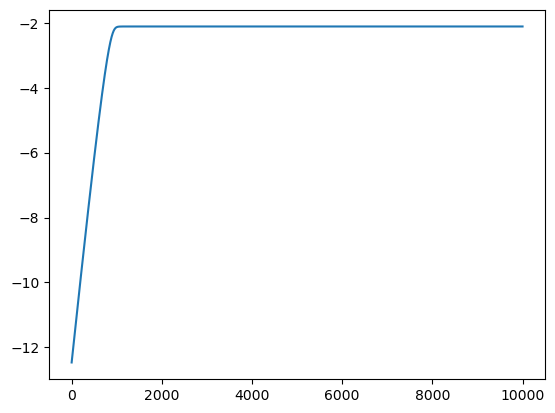

In [97]:
plt.plot(model_bayes.evidence_list)


In [98]:
print(model_bayes.w_vec)
print(np.sqrt(model_bayes.var_w_vec))

[-0.38872261 -0.72777472 -0.39269075]
[0.07362595 0.07144586 0.07307876]


In [99]:
print(model_bayes.mu)
print(model_bayes.Lambda)
print(model_bayes.alpha)

[-1.35948167e-07 -1.35948167e-07 -1.35948167e-07]
[[11.35402795 10.35377798 10.35377798]
 [10.35377798 11.35402795 10.35377798]
 [10.35377798 10.35377798 11.35402795]]
[0.04349443]
